In [1]:
import seml
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.dpi'] = 500

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seml/database.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
results = seml.get_results('hierarchical_runs', to_data_frame=True)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


In [92]:
results['result.classification_report.level_1'].iloc[0]

,precision,recall,f1-score,support
Endothelial,0.998497,0.994992,0.996741,19368.000000
Epithelial,0.994284,0.996371,0.995327,28108.000000
Immune,0.996943,0.997923,0.997432,63062.000000
Stroma,0.992461,0.988025,0.990238,11858.000000
accuracy,0.996144,0.996144,0.996144,0.996144
macro avg,0.995546,0.994328,0.994935,122396.000000
weighted avg,0.996144,0.996144,0.996142,122396.000000


In [103]:
def extract(
    x,
    t='weighted avg',
    metric='f1-score'
):
    try:
        w = x.loc[t][metric]
    except:
        w = np.nan
    return w
def process_df(df, metric='f1-score'):
    for i in range(1, 5):
        df[f'result.f1-score-weighted.level_{i}'] = df[f'result.classification_report_query.level_{i}'].apply(
            lambda x: extract(x, metric=metric)
        )
        df[f'result.f1-score-macro.level_{i}'] = df[f'result.classification_report_query.level_{i}'].apply(
            lambda x: extract(x, 'macro avg', metric=metric)
        )
        df[f'result.accuracy.level_{i}'] = df[f'result.classification_report_query.level_{i}'].apply(
            lambda x: extract(x, 'accuracy', metric='precision')
        )
    return df

In [104]:
def plot(df, metric):
    df = process_df(results)
    df_scores = df[df.columns[df.columns.str.contains(metric)]]
    df_scores.index = df['config.ann_levels'].astype('str')
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    df_plot = (
        df_scores
        .groupby(
            df_scores.index
        )
        .mean()
        .reindex([
            '[1]',
            '[2]',
            '[3]',
            '[4]',
            '[1, 2]',
            '[2, 3]',
            '[3, 4]',
            '[1, 2, 3]',
            '[2, 3, 4]',
            '[1, 2, 3, 4]'
        ])
    )
    df_std = (
        df_scores
        .groupby(
            df_scores.index
        )
        .std()
        .reindex([
            '[1]',
            '[2]',
            '[3]',
            '[4]',
            '[1, 2]',
            '[2, 3]',
            '[3, 4]',
            '[1, 2, 3]',
            '[2, 3, 4]',
            '[1, 2, 3, 4]'
        ])
    )
    labels = df_plot.round(2).astype('str') + ' + ' + df_std.round(2).astype('str')
    sns.heatmap(
        df_plot, 
        vmin=0, 
        vmax=1, 
        cmap='viridis', 
        annot=labels.astype('str'),
        fmt='',
        ax=ax
    )
    ax.set_title(metric)

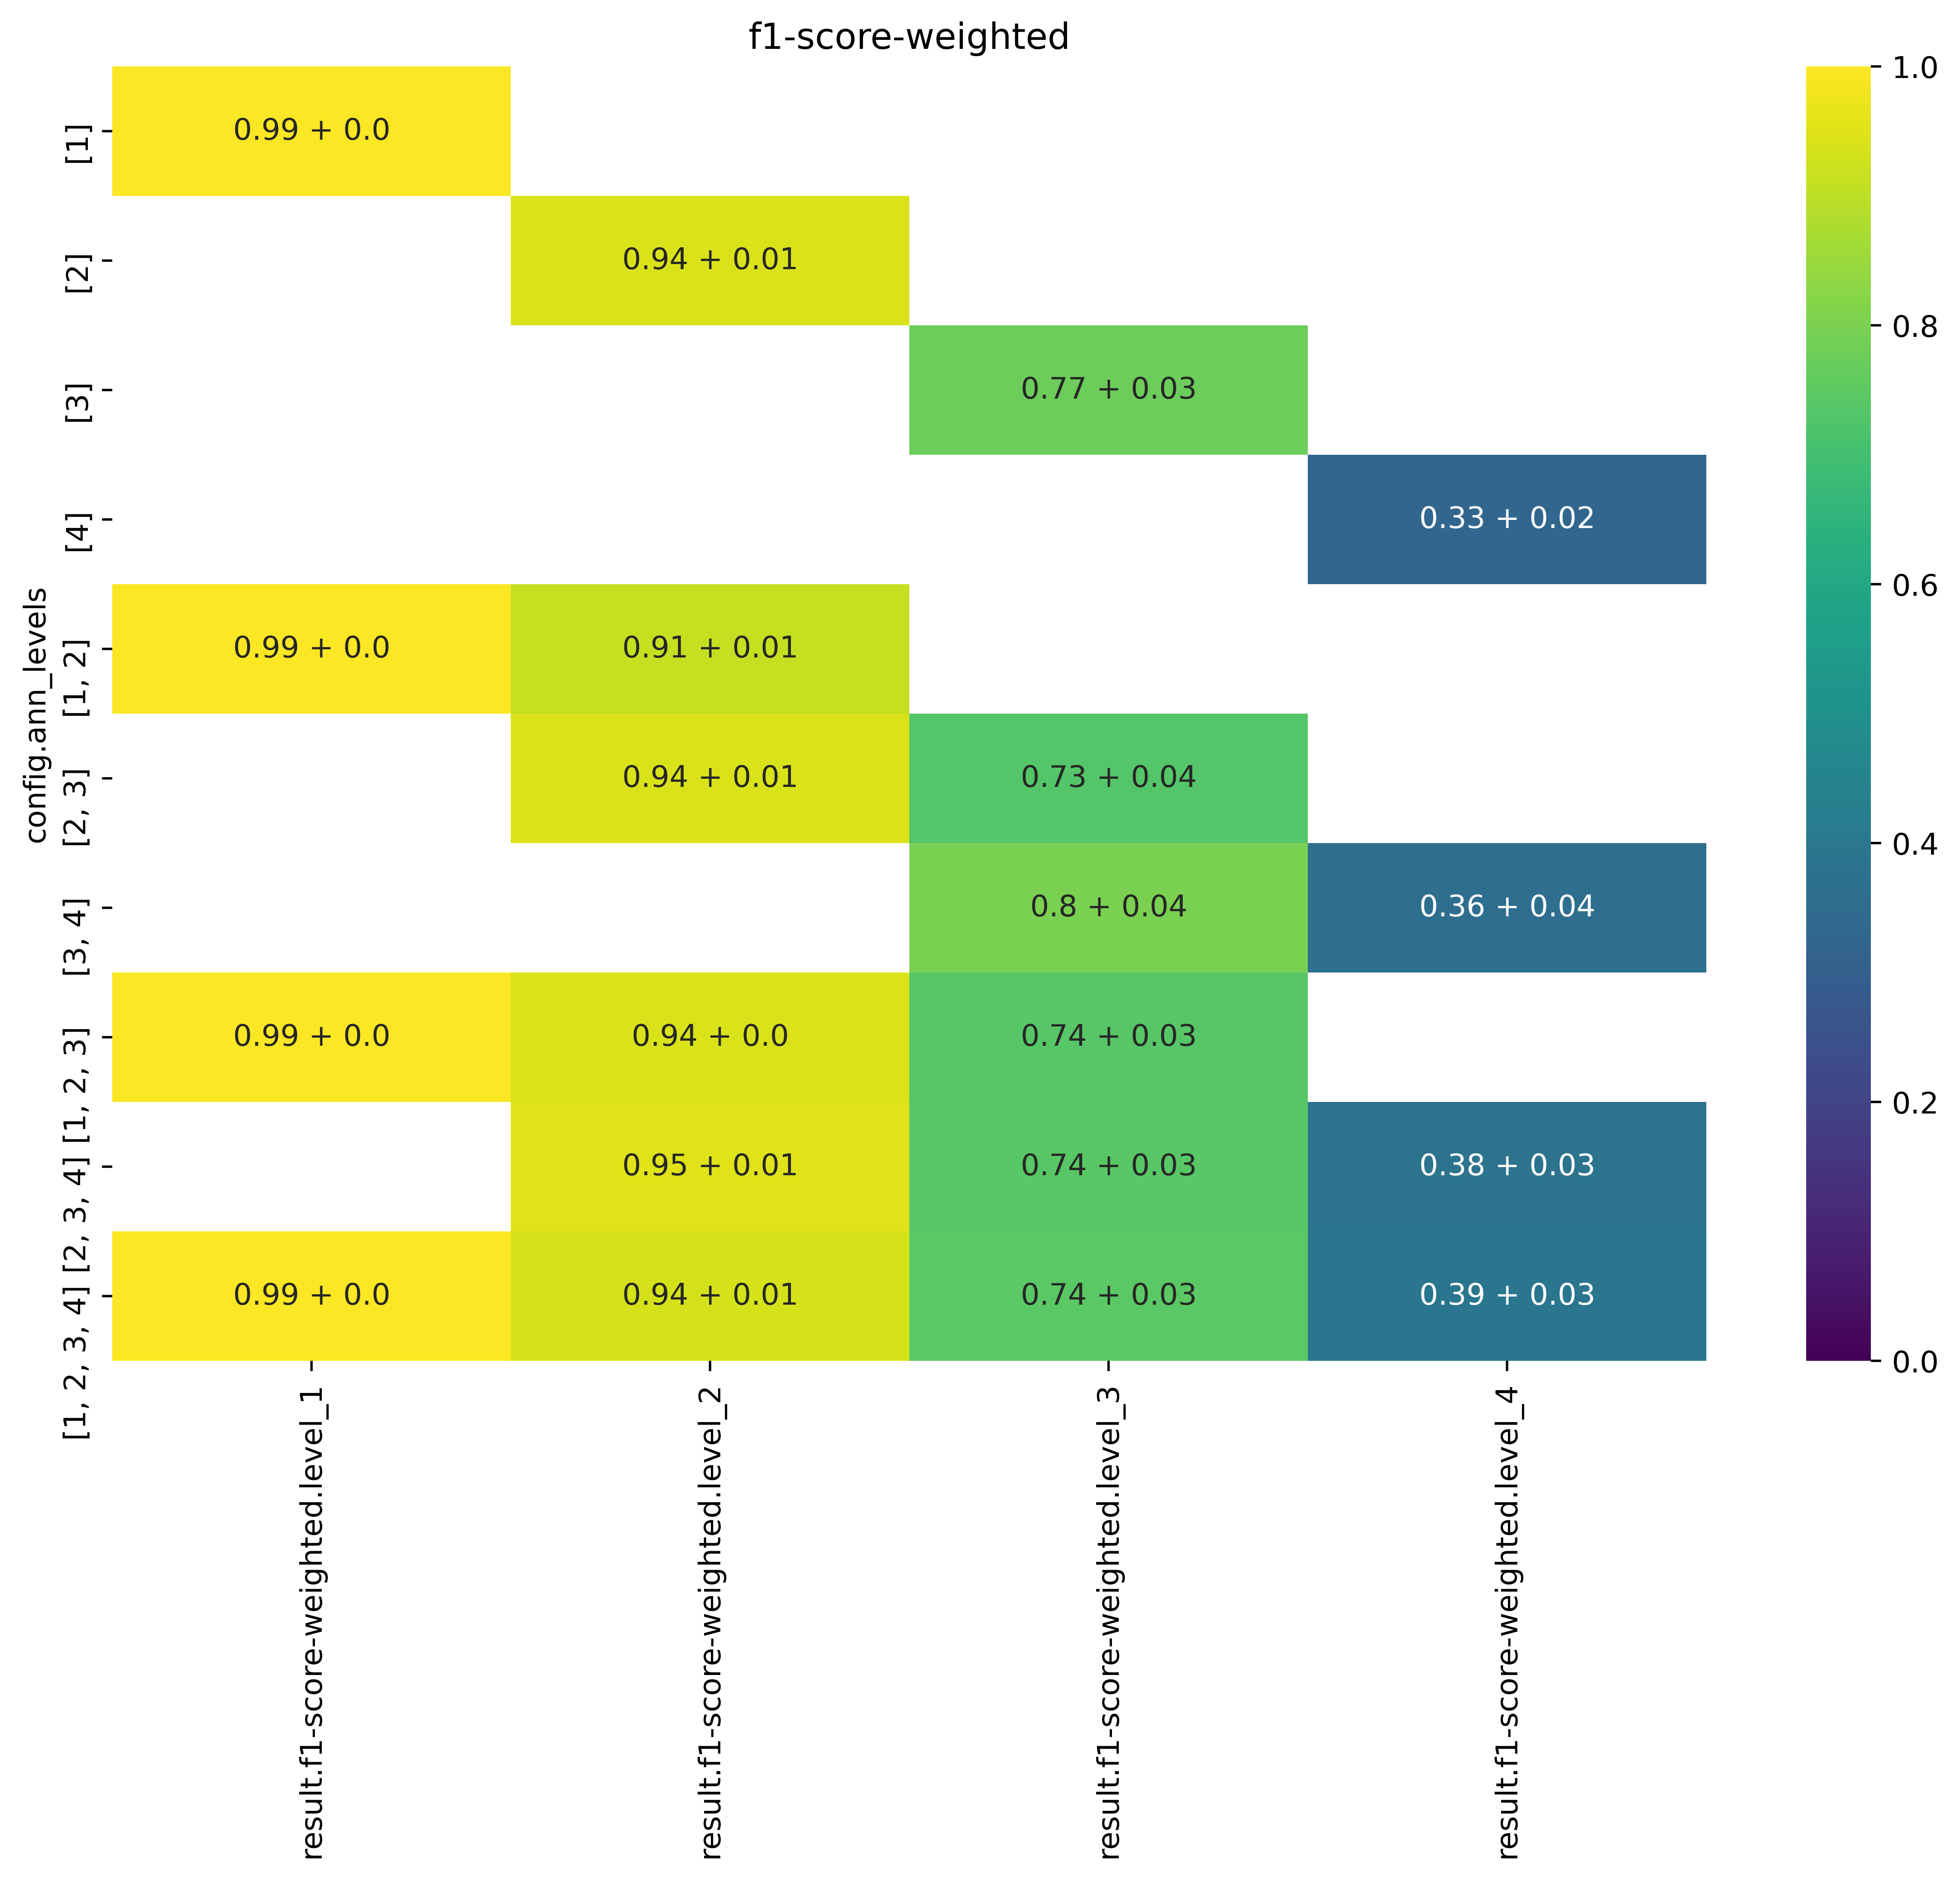

In [105]:
plot(df, 'f1-score-weighted')

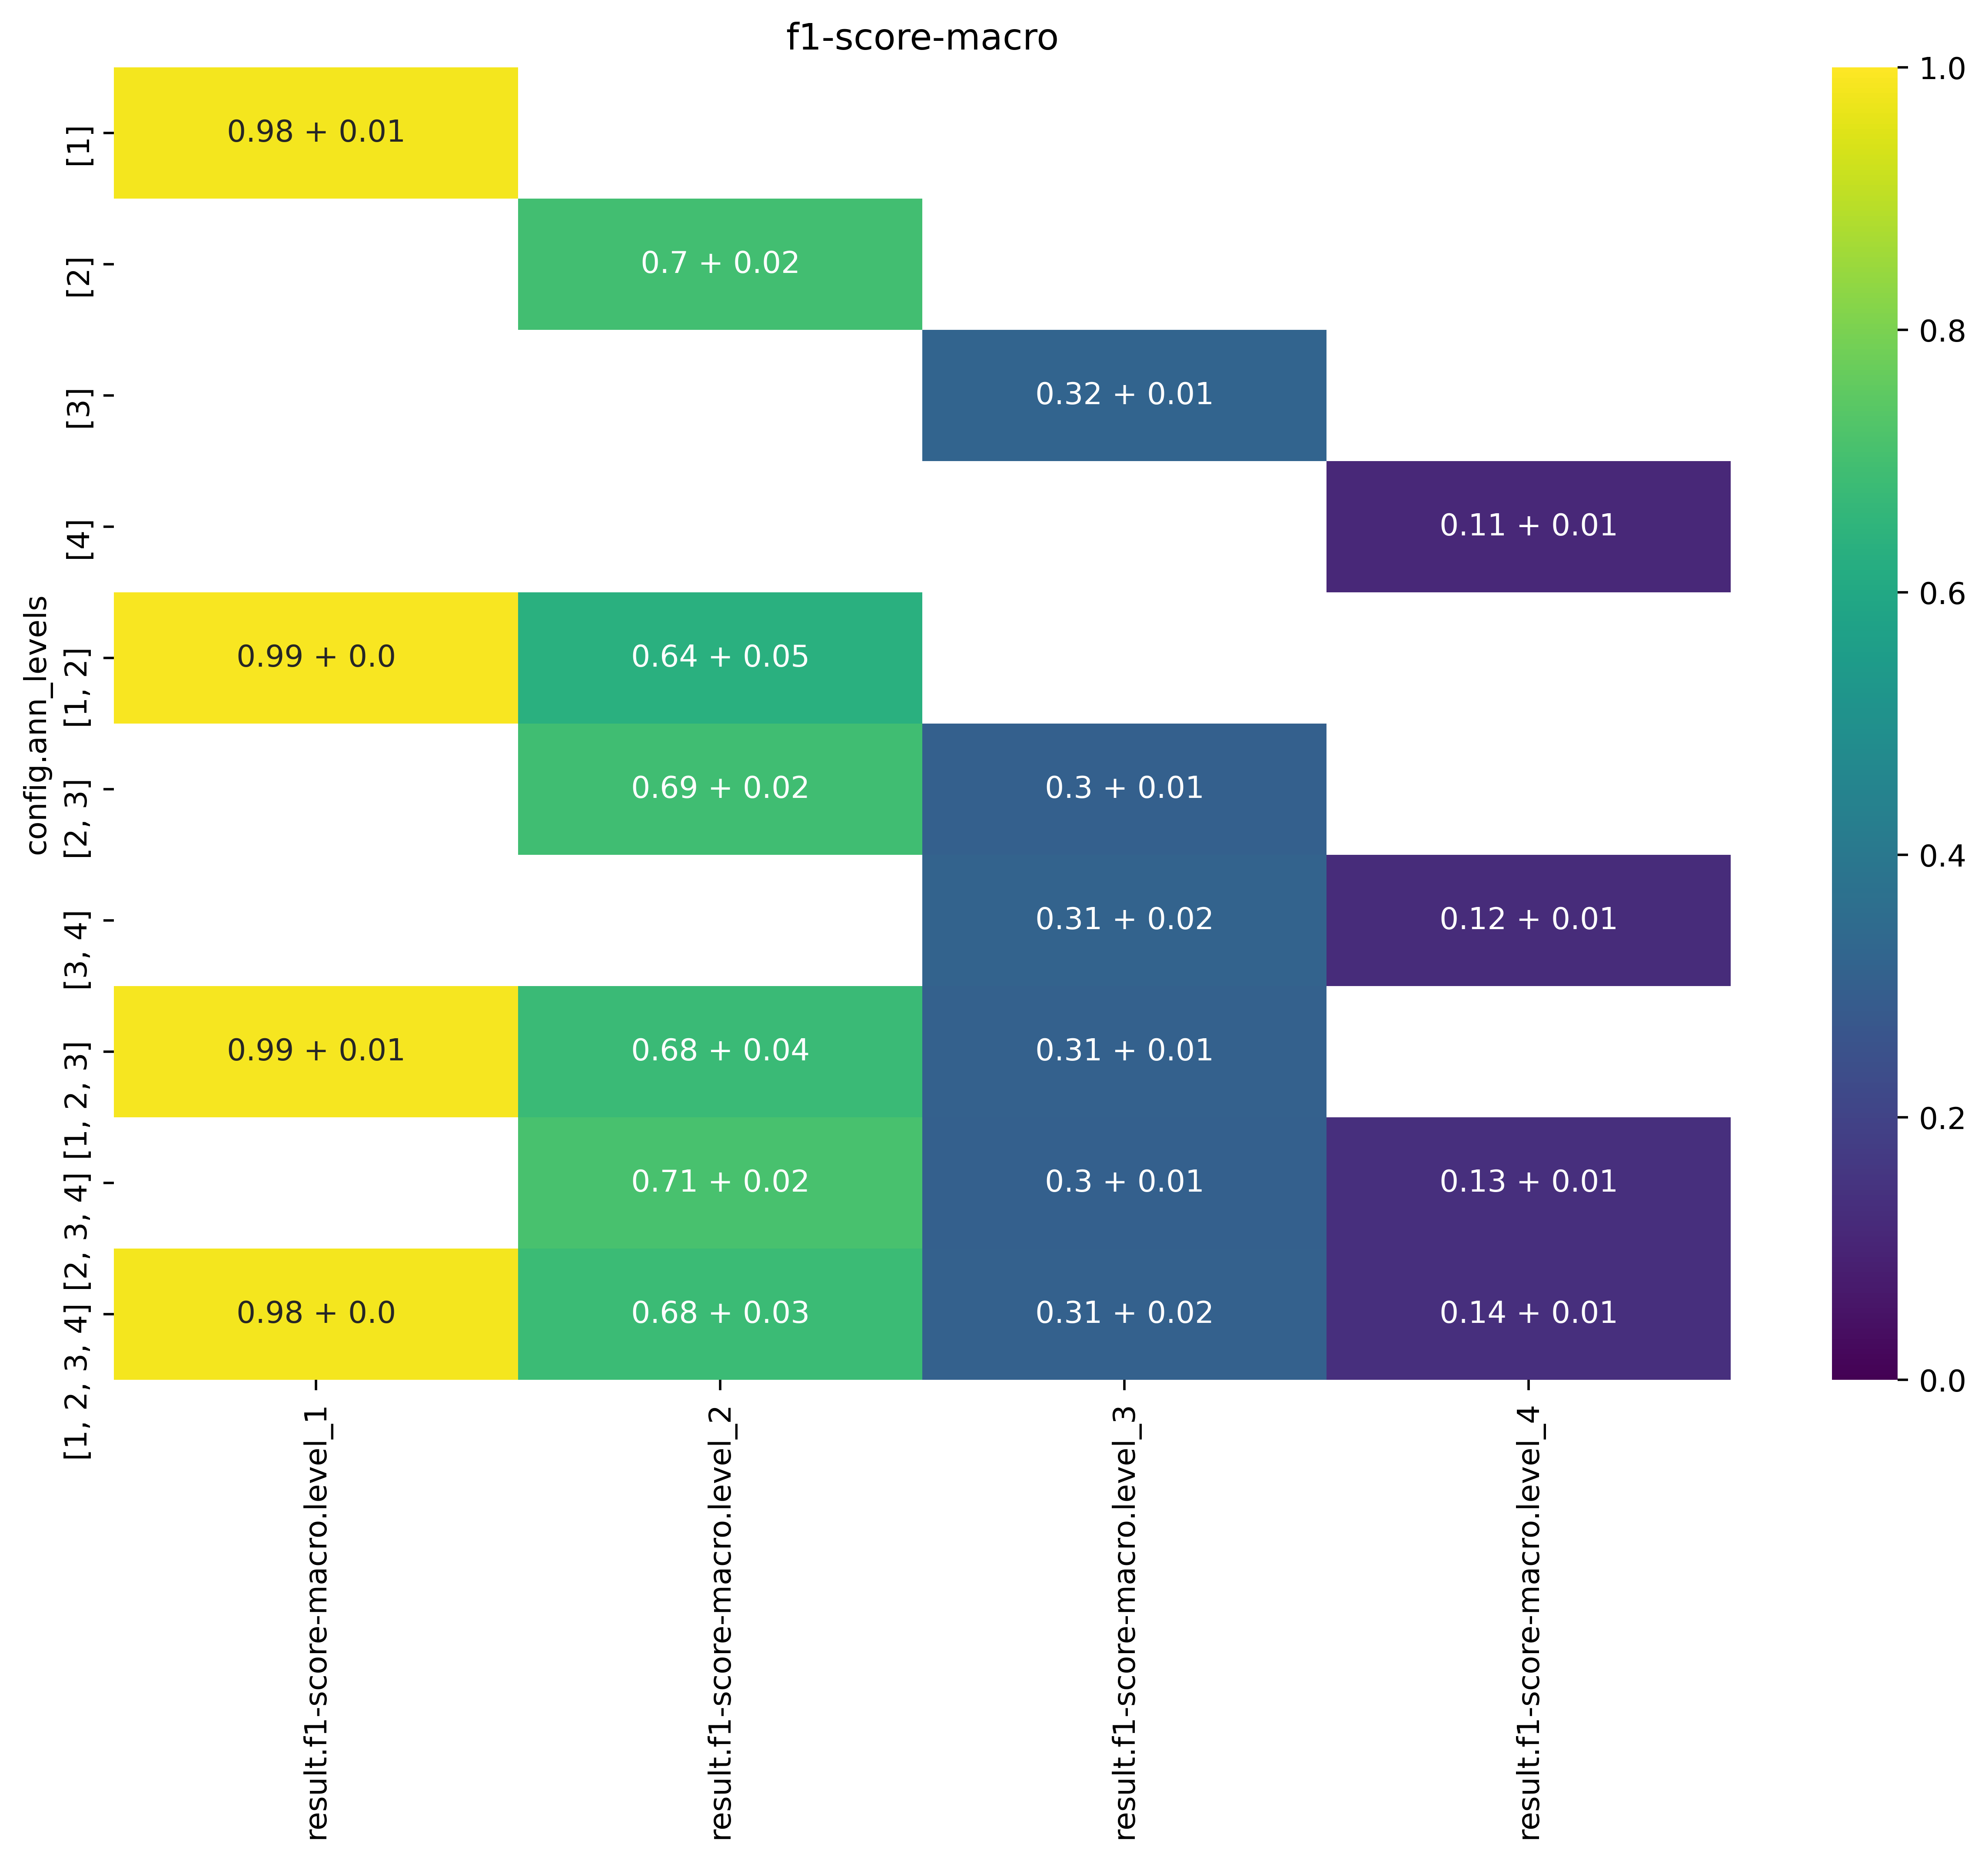

In [106]:
plot(df, 'f1-score-macro')

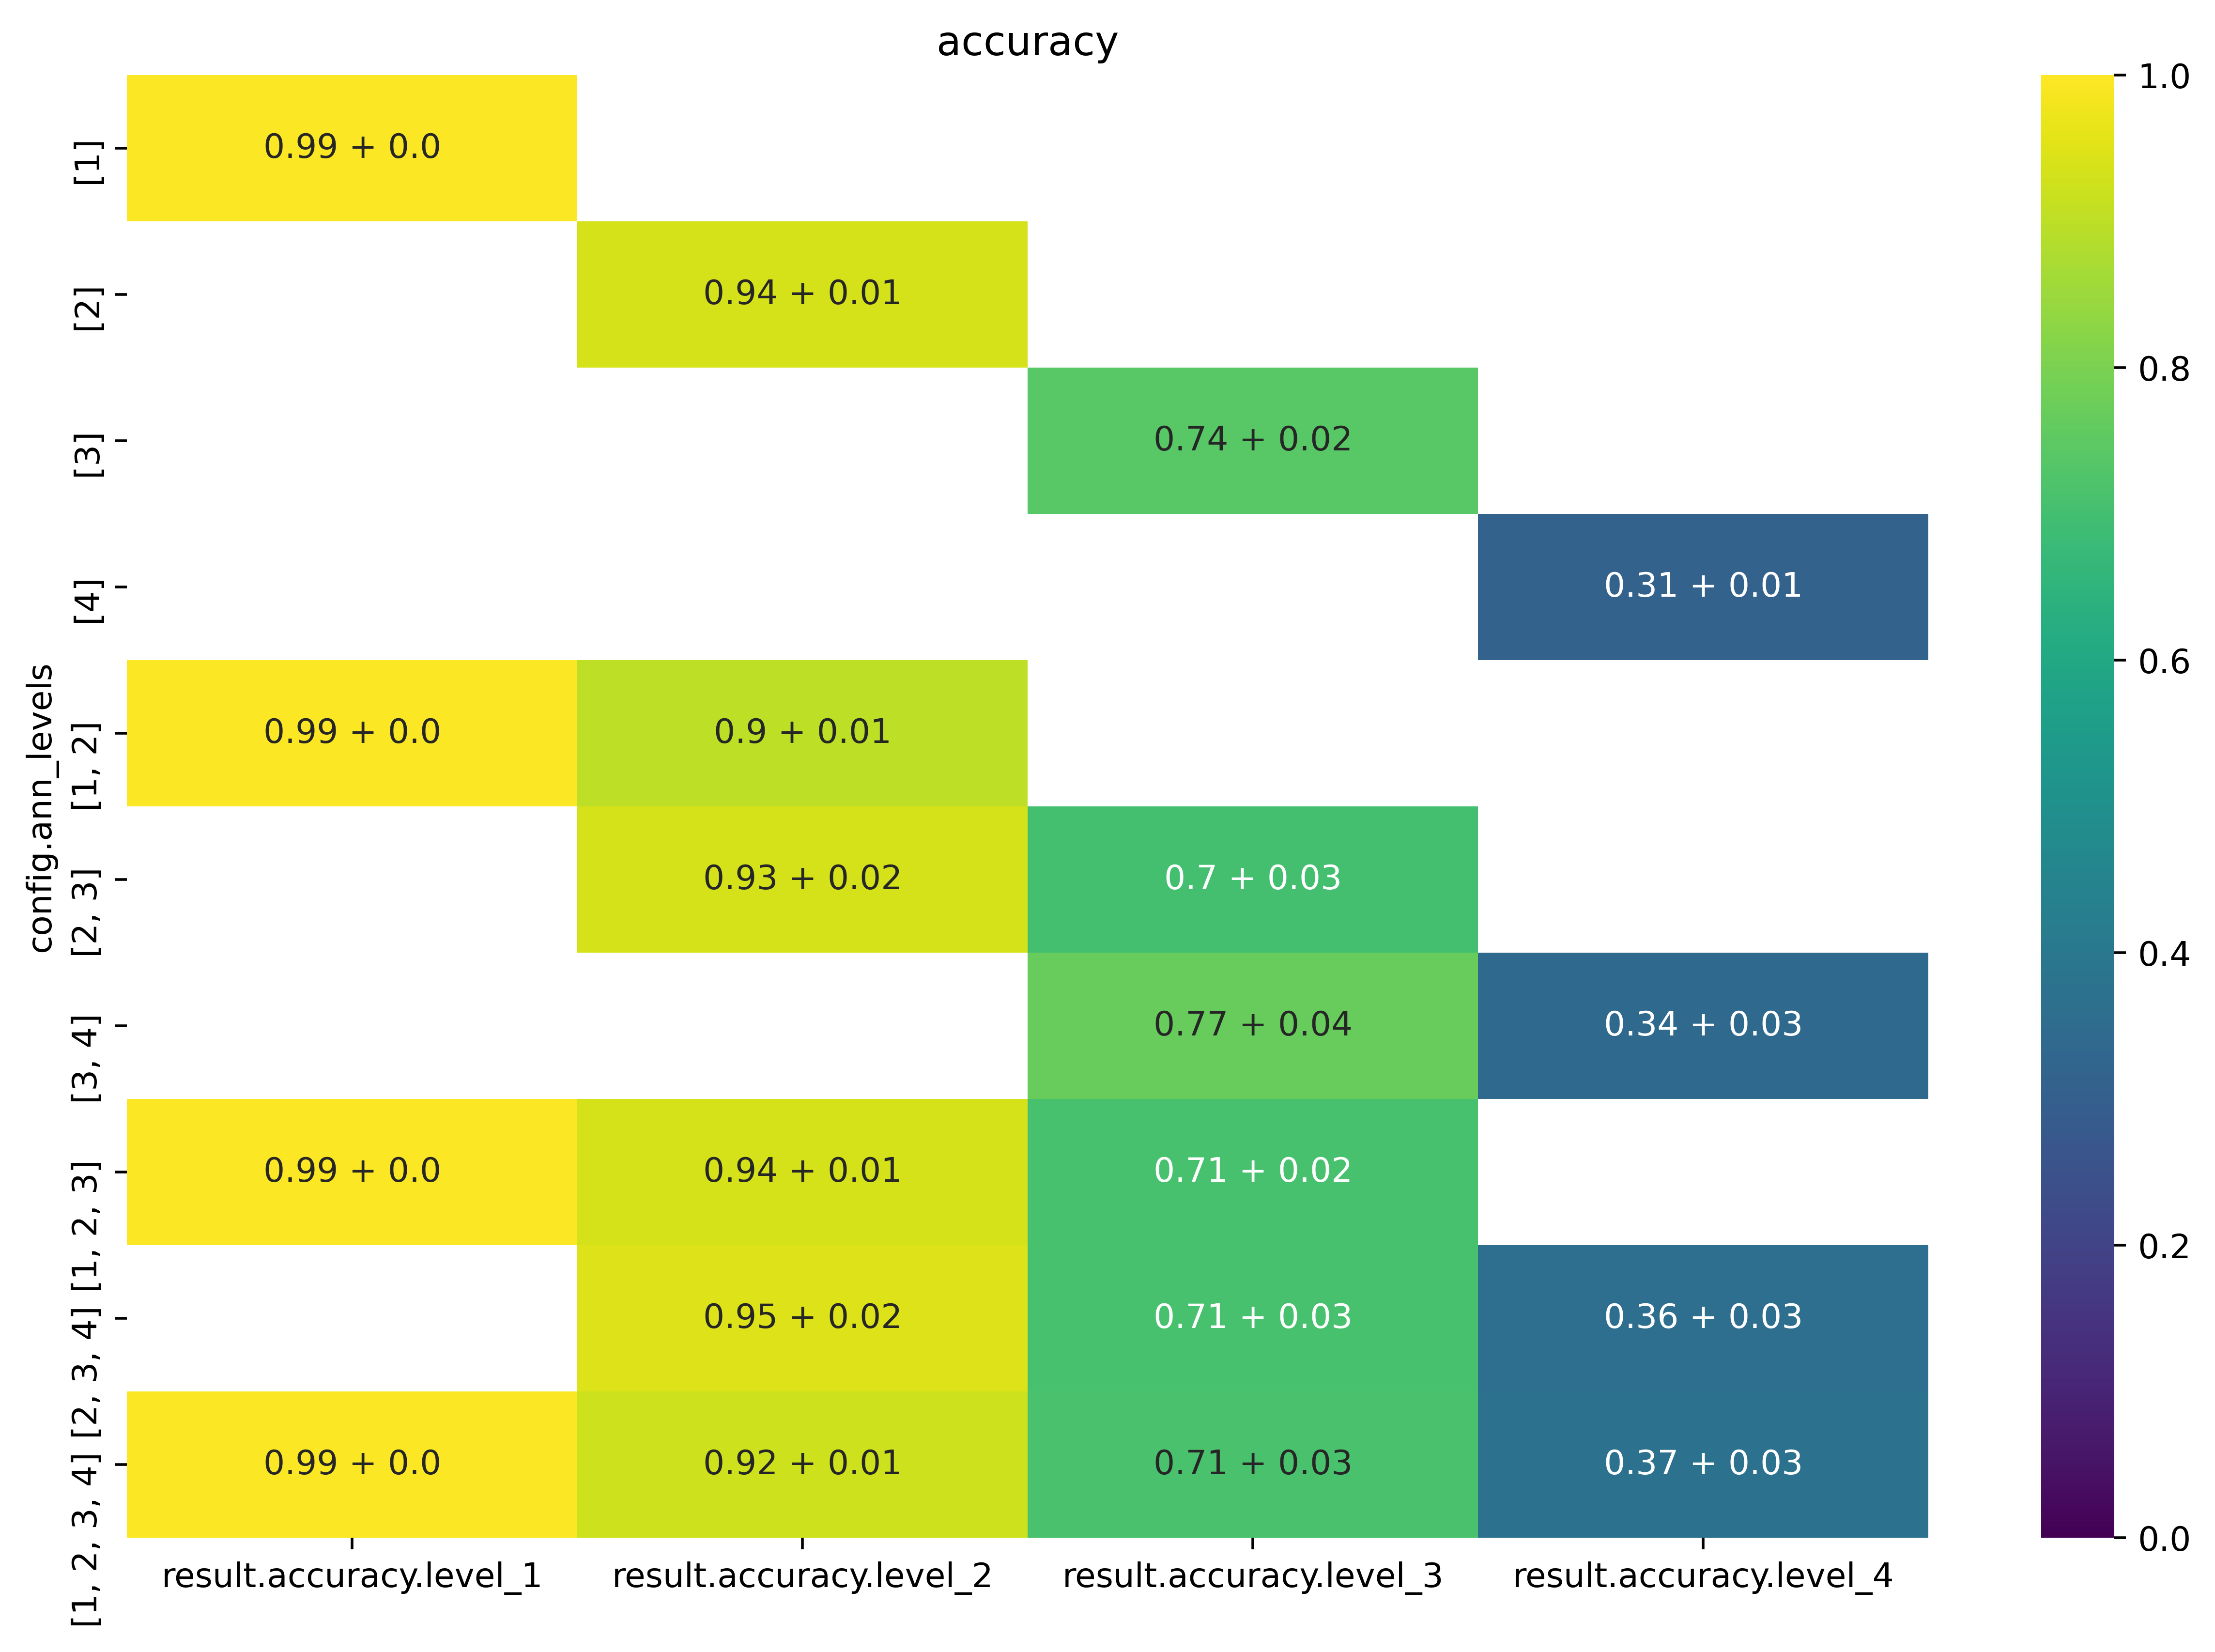

In [107]:
plot(df, 'accuracy')